In [1]:
NUM_CLASSES = 10

In [2]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

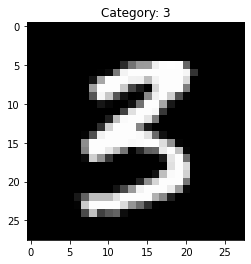

In [3]:
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

x_train, y_train = shuffle(x_train, y_train)
plt.imshow(x_train[0], cmap="gray")
plt.title(f"Category: {y_train[0]}")
plt.show()

In [4]:
import numpy as np
x_train = np.expand_dims(x_train, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)

x_train.shape, y_train.shape

((60000, 28, 28, 1), (60000, 1))

In [5]:
from tensorflow.keras.layers import Input, Conv2D, Dense, Activation, MaxPool2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

input_shape = x_train.shape[1:] # cutting off index 0 ===> img number

# input layer
input = Input(shape=input_shape)

# convolutional layers
x = Conv2D(filters=32, kernel_size=(4, 4), strides=2, padding="same")(input)
x = Activation("relu")(x)
x = Conv2D(filters=64, kernel_size=(2, 2), strides=1, padding="same")(x)
x = Activation("relu")(x)
x = MaxPool2D()(x) # POOLING
x = Conv2D(filters=64, kernel_size=(2, 2), strides=1, padding="same")(x)
x = Activation("relu")(x)
x = MaxPool2D()(x) # POOLING

# flatten
x = Flatten()(x)

# dense layer
x = Dense(128)(x)
x = Activation("relu")(x)

# output layer
out = Dense(NUM_CLASSES)(x)

DQN = Model(inputs=input, outputs=out)

In [6]:
DQN.compile(
    loss = "mean_squared_error",
    optimizer = Adam(lr=0.001)
    )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [7]:
from tensorflow.keras.utils import to_categorical

def get_data():
    return shuffle(x_train, y_train)

In [8]:
# Memory Buffer
from collections import deque
MEMORY_SIZE = 25000
MEMORY_BUFFER = deque(maxlen=MEMORY_SIZE)
TRAIN_START = 500

def save_choice(x, choice, reward):
    MEMORY_BUFFER.append([x, choice, reward])

In [9]:
GAMMA = 0 # future reward isn't important
BATCH_SIZE = 32

# Experience Replay
def replay():
    minibatch = random.sample(MEMORY_BUFFER, BATCH_SIZE)
    x_samples, choices, rewards = zip(*minibatch)

    q_values = DQN.predict(x_samples)

    for i in range(BATCH_SIZE):
        choice = choices[i]
        q_values[i][choice] = rewards[i] + GAMMA * np.max(q_values_next[i])

    DQN.fit(x_samples, q_values, batch_size=BATCH_SIZE, verbose=0)

In [10]:
# predict
EPSILON = 1
def choose(datapoint):
    if np.random.rand() <= EPSILON:
        return np.random.randint(NUM_CLASSES)
    else:
        return np.argmax(DQN(datapoint))

In [ ]:
EPSILON_MIN = 0.3
EPSILON_DECAY = 0.99

for _ in range(50):
    # get shuffled data
    x, y = get_data()
    sum_reward = 0
    for i in range(x_train.shape[0]):
        # choose a category
        choice = choose(x[i])

        # epsilon decay
        if EPSILON > EPSILON_MIN:
            EPSILON *= EPSILON_DECAY

        # reward choice
        reward = 0
        if y[i] == choice:
            reward = 1
        else:
            reward = 0

        sum_reward += reward

        # save in memory buffer
        save_choice(x, choice, reward)

        if len(MEMORY_BUFFER) >= TRAIN_START:
            replay()

    print(f"{sum_reward}/{x_train.shape[0]} right - Eps: {EPSILON}")

In [ ]:
# test